In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocess the image

In [31]:
def transform(pos):
    pts = []
    n = len(pos)
    for i in range(n):
        pts.append(list(pos[i][0]))
    sums = {}
    diffs = {}
    tl = tr = bl = br = 0
    for i in pts:
        x = i[0]
        y = i[1]
        sum = x + y
        diff = y - x
        sums[sum] = i
        diffs[diff] = i
    sums = sorted(sums.items())
    diffs = sorted(diffs.items())
    n = len(sums)
    
    rect = [sums[0][1], diffs[0][1], diffs[-1][1], sums[-1][1]]
    #	   top-left   top-right   bottom-left   bottom-right
    
    h1 = np.sqrt((rect[0][0] - rect[2][0]) ** 2 + (rect[0][1] - rect[2][1]) ** 2)  # height of left side
    h2 = np.sqrt((rect[1][0] - rect[3][0]) ** 2 + (rect[1][1] - rect[3][1]) ** 2)  # height of right side
    h = max(h1, h2)

    w1 = np.sqrt((rect[0][0] - rect[1][0]) ** 2 + (rect[0][1] - rect[1][1]) ** 2)  # width of upper side
    w2 = np.sqrt((rect[2][0] - rect[3][0]) ** 2 + (rect[2][1] - rect[3][1]) ** 2)  # width of lower side
    w = max(w1, w2)

    return int(w), int(h), rect

In [32]:
def preprocess_image_top_view(img):
    '''
    Input: numpy array
        Image containing A4 and some noise background
    
    1. Change from BGR to Gray
    2. GaussianBlur
    3. Canny Edge Detection
    4. Find Biggest Contour
    5. call transform(pos)
    6. getPerspectiveTransform and warpPerspective
    
    Output: numpy array
        Image containing A4 Paper only
    '''

    r = 500.0 / img.shape[0]
    dim = (500, int(img.shape[0] * r))
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edge = cv2.Canny(gray, 100, 200)
    
    rows = edge.shape[0]
    cols = edge.shape[1]
    
    
    _, contours, _ = cv2.findContours(edge.copy(), 1, 1)
    n = len(contours)
    max_area = 0
    pos = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > max_area:
            max_area = area
            pos = i
    
    
    
    
    peri = cv2.arcLength(pos, True)
    approx = cv2.approxPolyDP(pos, 0.02 * peri, True)
    size = img.shape
    
    w, h, arr = transform(approx)


    pts2 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
    pts1 = np.float32(arr)
    M = cv2.getPerspectiveTransform(pts1, pts2)
    edge = cv2.warpPerspective(edge, M, (w, h))
    return edge
    
    

In [33]:
def extract_foot_length_and_foot_width(edge):
    '''
    Input: numpy array
        an image only contains a foot and A4 paper with foot heel touching the bottom of A4 paper
    
    Return: int, int
        foot_length and foot_width
    '''
    plt.imshow(edge)
    plt.savefig('foot_length.pdf')
    #foot lenght
    w = edge.shape[1]
    edge[0:10,:]=0
    edge[:,0:10]=0
    edge[:,w-10:w]=0
    top_toe_r=0
    rows = edge.shape[0]
    cols = edge.shape[1]
    
    
    for r in range(10,rows):
        if len(np.unique(edge[r,:])) ==1:
            continue
        elif len(np.unique(edge[r,:])) >=2:
            top_toe_r = r
            foot_length = rows-r
            A4_length = rows
            foot_length = foot_length*27.9/A4_length
            #accuracy = (25.5/foot_length)
            print('foot_length = {} cm'.format(foot_length))
            break
            
    
    #foot width   
    start = top_toe_r+30
    end   = round(top_toe_r + (rows-top_toe_r)/2 + (rows-top_toe_r)/5)
    max_c = 0
    min_c = edge.shape[1]
    
    for r in range(start, end):
        c = np.where(edge[r,:] > 1)
        if c[0].shape[0] <= 1:
            continue
        elif c[0].shape[0] >= 2:
            if c[0][0]  < min_c:
                min_c = c[0][0]
            if c[0][-1] > max_c:
                max_c = c[0][-1]
    
    if max_c-min_c > 0:
        foot_width = (max_c - min_c)*21.5/ edge.shape[1]
        print('Width    = {} cm'.format( foot_width ))
        
        
    return foot_length, foot_width
        

In [34]:
def extract_foot_toe_height_and_foot_back_height(img, predicted_foot_length):
    '''
    Input: numpy array
        image of foot from side view
        
    Output: numpy array
        processed image
    '''
    
    
    #1. GaussianBlur
    img = cv2.GaussianBlur(img, (11,11), 0)
    
    #2. convert image to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    #3. set yellow and red color boundary
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    lower_red    = np.array([0 , 150, 100])
    upper_red    = np.array([10, 255, 255])
    
    #4. filter other colors out
    #    mask_yellow only contains yellow colors
    #    mask_red    only contains red colors 
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_red    = cv2.inRange(hsv, lower_red   , upper_red   )
    
    #5. pts_yellow except yellow points, other points are black
    # . pts_red    except red    points, other points are red
    pts_yellow = cv2.bitwise_and(img, img, mask=mask_yellow)
    pts_red    = cv2.bitwise_and(img, img, mask=mask_red)
    
    
    rows = pts_yellow.shape[0]
    cols = pts_yellow.shape[1]

    
    #6. locating 4 points
    max_c = 0
    min_c = cols
    first = False
    for c in range(0,cols):
        if len(np.unique(pts_yellow[:,c])) == 1:
            continue
        elif len(np.unique(pts_yellow[:,c])) >= 2:
            if(first==False):
                min_c = c
                first=True
            elif c>max_c:
                max_c = c
    
    max_r = 0
    min_r = rows
    for r in range(0,rows):
        if   len(np.unique(pts_yellow[r,:])) == 1:
            continue
        elif len(np.unique(pts_yellow[r,:])) >= 2:
            if r < min_r:
                min_r = r
            if r > max_r:
                max_r = r
    
    #7. diff_c is the distance in pixel of Toe Height
    # . diff_r is the distance in pixel of Foot Length
    
    diff_c = max_c - min_c
    diff_r = max_r - min_r
    Toe_Height = diff_r*predicted_foot_length/diff_c
    
    print("Toe Height= {} cm".format(Toe_Height))
    
    #8. Calculate Foot Back Height
    foot_back_height = 0
    for r in range(0,rows):
        if   len(np.unique(pts_red[r,:])) == 1:
            continue
        elif len(np.unique(pts_red[r,:])) >= 2:
            foot_back_height = r
            break
            
    foot_back_height = (max_r-foot_back_height)*predicted_foot_length/diff_c
    scaling_factor = predicted_foot_length / diff_c
    #print('scaling_factor = {}'.format(predicted_foot_length/diff_c))
    
    print('Foot Back Height = {} cm'.format( foot_back_height))
    
    return Toe_Height, foot_back_height, scaling_factor
                
        
    
    
    


In [35]:
def preprocess_image_for_a(img):
    r = 500.0 / img.shape[0]
    dim = (500, int(img.shape[0] * r))
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    gray = cv2.GaussianBlur(img, (5, 5), 0)
    edge = cv2.Canny(gray, 100, 200)
    
    rows = edge.shape[0]
    cols = edge.shape[1]
    
    
    _, contours, _ = cv2.findContours(edge.copy(), 1, 1)
    n = len(contours)
    max_area = 0
    pos = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > max_area:
            max_area = area
            pos = i
    
    
    
    
    peri = cv2.arcLength(pos, True)
    approx = cv2.approxPolyDP(pos, 0.02 * peri, True)
    size = img.shape
    
    w, h, arr = transform(approx)
    pts2 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
    pts1 = np.float32(arr)
    M = cv2.getPerspectiveTransform(pts1, pts2)
    edge = cv2.warpPerspective(img, M, (w, h))
    return edge

In [36]:
def extract_a(img):
    
#    plt.imshow(cv2.cvtColor(mask_red, cv2.COLOR_BGR2RGB))    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_red    = np.array([0 , 150, 100])
    upper_red    = np.array([10, 255, 255])
    mask_red    = cv2.inRange(hsv, lower_red   , upper_red   )
    
    rows = mask_red.shape[0]
    cols = mask_red.shape[1]


    max_c = 0
    min_c = cols
    for c in range(0, cols):
        if len(np.unique(mask_red[:,c])) == 1:
            continue
        elif len(np.unique(mask_red[:,c])) >=2:
            if c > max_c:
                max_c = c
            if c < min_c:
                min_c = c
    
    print('max_c = {}'.format(max_c))
    print('min_c = {}'.format(min_c))
    two_a = (max_c - min_c) * 21.5/ mask_red.shape[1]
    a = two_a/2
    print('a = {} cm'.format(a))

    return a


In [37]:
def extract_b(img, scaling_factor):

    img = cv2.GaussianBlur(img, (11,11), 0)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_red    = np.array([160, 100, 100])
    upper_red    = np.array([179, 255, 255])



    mask_red    = cv2.inRange(hsv, lower_red   , upper_red   )
    
    rows = mask_red.shape[0]
    cols = mask_red.shape[1]

    max_c = 0
    min_c = cols

    max_r = 0
    min_r = rows

    for c in range(0, cols):
        if len(np.unique(mask_red[:,c])) == 1:
            continue
        elif len(np.unique(mask_red[:,c])) >= 2:
            if c < min_c:
                min_c = c
            if c > max_c:
                max_c = c

    diff_c = max_c - min_c
    diff_c = diff_c# * scaling_factor


    for r in range(0, rows):
        if len(np.unique(mask_red[r,:])) == 1:
            continue
        elif len(np.unique(mask_red[r,:])) >= 2:
            if r < min_r:
                min_r = r
            if r > max_r:
                max_r = r

    diff_r = max_r - min_r
    diff_r = diff_r# * scaling_factor

    b = (diff_c**2 + diff_r**2)**0.5
    b = b/2
    b = b*scaling_factor
    print("b = {} cm".format(b))


    return b

In [38]:
def extract_heel_circumference(a,b):
    heel_circumference = np.pi*(3*(a+b) - np.sqrt((3*a+b)*(a+3*b)))
    return heel_circumference

In [39]:
def extract_foot_circumference(a, foot_width):
    foot_circumference = np.pi * (a)
    foot_circumference = foot_circumference + 2*a
    return foot_circumference

In [40]:
def participant(person):
    img = cv2.imread('/Users/kevincheung/Documents/PycharmProjects/Foot_Shape_Analysis/Participants/'+person+'/top_view.jpg')
    edge = preprocess_image_top_view(img)
    params = {}
    params['foot_length'], params['foot_width'] = extract_foot_length_and_foot_width(edge)


    img = cv2.imread('/Users/kevincheung/Documents/PycharmProjects/Foot_Shape_Analysis/Participants/'+person+'/side_view_1.jpg')
    params['toe_height'], params['foot_back_height'], scaling_factor = extract_foot_toe_height_and_foot_back_height(img, params['foot_length'])

    img = cv2.imread('/Users/kevincheung/Documents/PycharmProjects/Foot_Shape_Analysis/Participants/'+person+'/top_view_2.jpg')
    img = preprocess_image_for_a(img)
    a = extract_a(img)
    
    img = cv2.imread('/Users/kevincheung/Documents/PycharmProjects/Foot_Shape_Analysis/Participants/'+person+'/side_view_2.jpg')
    b = extract_b(img, scaling_factor)
    params['heel_circumference'] = extract_heel_circumference(a, b)
    params['foot_circumference'] = extract_foot_circumference(a, params['foot_width'])
    return params



foot_length = 24.10957683741648 cm
Width    = 10.75 cm
Toe Height= 2.583647045875281 cm
Foot Back Height = 10.977153251905339 cm
max_c = 310
min_c = 119
a = 4.406115879828326 cm
b = 5.69207461174931 cm


{'foot_length': 24.10957683741648,
 'foot_width': 10.75,
 'toe_height': 2.583647045875281,
 'foot_back_height': 10.977153251905339,
 'heel_circumference': 31.853149284128794,
 'foot_circumference': 22.654453038590653}

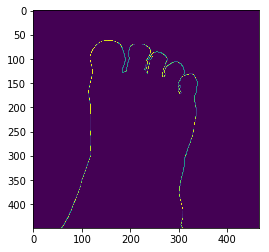

In [42]:
participant("YingDing")